In [1]:
import os
import re
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
vault_path = r"C:\Users\paulm\OneDrive\OneVault"
daily_notes_folder = r"\+ journal\daily"

In [3]:
def find_markdown_files(folder_path):
    markdown_files = []
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".md"):
                markdown_files.append(os.path.join(root, file))
    
    return markdown_files

In [4]:
def read_markdown_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        contents = file.read()
    return contents

In [5]:
def extract_activity(itemText):
    result = re.search(r'\](.*?)\[', itemText).group(1)
    return result.strip()

In [6]:
def extract_pts(itemText):
    points = 0
    penalty = 0
    ptsr = re.search(r'\[pts::\s*(\d+)\]', itemText)
    penlr = re.search(r'\[penalty::\s*(\d+)\]', itemText)
    if ptsr:
        points = int(ptsr.group(1))
    if penlr:
        penalty = int(penlr.group(1))
    return points, penalty

In [7]:
def date_range_df():
    end_date = datetime.today()
    start_date = end_date - timedelta(days=59)

    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    date_range_formatted = date_range.strftime('%Y-%m-%d')

    df = pd.DataFrame({'date': date_range_formatted})

    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

    return df

In [8]:
def calculate_score(mdc):
    score_items = [line for line in mdc if '::' in line]
    if not score_items:
        return 0
    
    pld = []
    for item in score_items:
        points, penalty = extract_pts(item)
        pld.append(
            {
                "activity": extract_activity(item),
                "complete": "- [x]" in item,
                "level": item.count("\t"),
                "points": points,
                "penalty": penalty
            }
        )

    df = pd.DataFrame(pld)

    item = 0
    for i, row in df.iterrows():
        if row['level'] == 0:
            item = item+1
        df.loc[i, 'item'] = item
    
    agg = df.groupby(['item', 'level', 'complete'])[['points', 'penalty']].sum().reset_index().sort_values(by=["item", "level"])

    pts_df = agg[(agg['complete'] == True) & (agg['penalty'] == 0)]
    pnl_df = agg[(agg['complete'] == False) & (agg['penalty'] > 0)]

    total = pts_df.groupby('item')['points'].prod().reset_index()['points'].sum() - pnl_df.groupby('item')['penalty'].prod().reset_index()['penalty'].sum()

    return total

In [9]:
def main():
    payload = []
    mdFiles = find_markdown_files(vault_path+daily_notes_folder)
    for file in mdFiles:
        mdc = read_markdown_file(file).split('\n')
        filename = file.rsplit('\\', maxsplit=1)[-1].split('.')[0]
        score = calculate_score(mdc)
        payload.append({"date": filename, "score": score})
    df = pd.DataFrame(payload)
    date_range = date_range_df()
    
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

    return pd.merge(date_range, df, on='date', how='left')

In [10]:
df = main()

In [11]:
df['day'] = df['date'].apply(lambda x: x.strftime('%A'))
df['week'] = df['date'].apply(lambda x: x.strftime('%W'))
df['score'] = df['score'].apply(lambda x: -99 if x<-99 else x)

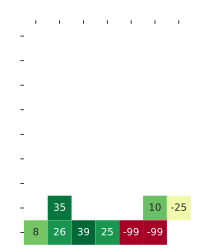

In [12]:
pv = pd.pivot(data = df, index='week', columns='day', values='score')
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pv = pv[weekday_order]
pv.columns = [col[:3] for col in pv.columns]
plt.figure(figsize=(3,4))
sns.heatmap(pv, cmap='RdYlGn', annot=True, cbar=False)
ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.ylabel("")
plt.xticks(color="white")
plt.yticks(color="white")
plt.savefig(r"C:\Users\paulm\OneDrive\OneVault\attachments\efficiency_tracker.png", dpi=200, transparent=True)
plt.show()